<a href="https://colab.research.google.com/github/getnetdemil/learngit/blob/master/MNIST_digit_generation_with_a_GAN_%5Bcloze%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a generative adversarial network (GAN) on the MNIST dataset

This notebook will show how to train a simple GAN to generate handwritten digits similar to those found in the MNIST dataset.

**Important:** Set the Cloab environment to run on GPU (Edit->Notebook Settings)

Author: Kevin McGuinness (kevin.mcguinness@dcu.ie). Credit to Albert Pumarola (apumarola@iri.upc.edu) upon whose work this Colab was based.


## Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

In [ ]:
%load_ext tensorboard

In [ ]:
device = 'cuda'
batch_size = 100

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision import datasets
from torchvision import utils

## Load the dataset
Download and prepare the [MNIST](http://yann.lecun.com/exdb/mnist) dataset. Here we resize the original $28\times 28$ images to be $32 \times 32$, which will simplify the implementation of the generator and discriminator.


In [ ]:
transform = transforms.Compose([
    transforms.Resize(32, interpolation=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))              
])
dataset = datasets.MNIST('data', transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(dataset.data.size())
imshow(dataset[0])

torch.Size([60000, 28, 28])


## Define the discriminator and generator networks
We will use a simple 4 layer generator network. The generator consists a fully layer followed by three transposed convolutions (and some batch norm). The output activation is a $\tanh$, which maps the final generated pixels to $[-1, 1]$.

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
      
        # 100 -> 1024 x 4 x 4
        self.fc = nn.Linear(100, 1024 * 4 * 4)

        # 1024 x 4 x 4 -> 512 x 8 x 8
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        # 512 x 8 x 8 -> 256 x 16 x 16
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(???),
            nn.BatchNorm2d(???),
            nn.ReLU(inplace=True))
        
        # 256 x 16 x 16 -> 1 x 32 x 32
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 1, 4, 2, 1),
            nn.Tanh())
        
        # initialize weights
        self.apply(init_weights)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

Similarly, we will define a four layer generator with three convolution layers and one fully connected. This network maps a $32 \times 32$ image to the probability that it is a real image.



In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # 1 x 32 x 32 -> 128 x 16 x 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True))
        
        # 128 x 16 x 16 -> 256 x 8 x 8 (no bias)
        self.conv2 = nn.Sequential(
            nn.Conv2d(???),
            nn.BatchNorm2d(???),
            nn.LeakyReLU(0.2, inplace=True))
        
        # 256 x 8 x 8 -> 512 x 4 x 4
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True))
        
        # 512 x 4 x 4 -> 1
        self.fc = nn.Linear(512 * 4 * 4, 1)

        # initialize weights
        self.apply(init_weights)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 512 * 4 * 4)
        x = torch.sigmoid(self.fc(x))
        return x

## Setup the optimization algorithm

We want to optimize the GANs loss:

$$\underset{G}{\min}\,\underset{D}{\max}\, \mathbb{E}_{x\sim p_{data}(x)}\big[\log D(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[\log(1-D(G(z)))\big]$$

To achieve this, we will alternate between fixing the discriminator weights and training the generator and fixing the generator weights and training the discriminator. In the generator training step, we want to try to fool the discriminator with fake images, i.e. we want $D(G(z))$ to be close to one, or $\log D(G(z))$ to be large. In the discriminator training step, we want $\log D(x)$ to be large and $\log D(G(z))$ to be small.

In [ ]:
# create the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

ones = torch.ones(batch_size, 1, device=device)
zeros = torch.zeros(batch_size, 1, device=device)

cross_entropy = nn.BCELoss()

generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


def generator_train_step(fake_samples):
    generator_optimizer.zero_grad()

    # D(G(z))
    fake_preds = discriminator(fake_samples)

    # loss = -log D(G(z))
    generator_loss = cross_entropy(???, ones)

    # backprop to generator
    generator_loss.backward()

    # update weights
    generator_optimizer.step()

    return generator_loss


def discriminator_train_step(real_samples, fake_samples):
    discriminator_optimizer.zero_grad()

    # D(x)
    real_preds = discriminator(???)

    # D(G(z))
    fake_preds = discriminator(???)

    # loss = -[ log D(x) + log (1 - D(G(z))) ] 
    real_loss = cross_entropy(real_preds, ones)
    fake_loss = cross_entropy(???, zeros)
    discriminator_loss = (real_loss + fake_loss) / 2.0

    # backprop to discriminator
    discriminator_loss.backward()

    # update weights
    discriminator_optimizer.step()

    return discriminator_loss


def train_step(real_samples):

    # create fake samples
    noise = torch.randn(real_samples.size(0), 100, device=device)
    fake_samples = generator(noise)

    # train generator (1 batch of fake samples)
    generator_loss = generator_train_step(fake_samples)

    # train discriminator (1 batch of real and 1 batch of fake samples)
    discriminator_loss = discriminator_train_step(real_samples, fake_samples.detach())

    return generator_loss.item(), discriminator_loss.item()


## Train the model

Let's create a tensorboard to monitor progress. The images tab will contain a validation sample from the model which will be updated every 100 iterations.



In [ ]:
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

Time to train!

In [ ]:
# fixed noise to use for generation of validation samples
z_val = torch.randn(25, 100, device=device)

# for communication with tensorboard
writer = SummaryWriter(flush_secs=5)

# train for
epochs = 25

# keep track of the number of training steps completed
iteration = 1

In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch} of {epochs}')
  
    # Train epoch
    for real_samples, _ in loader:
        
        # Prepare batch data
        real_samples = real_samples.to(device)
          
        # Update model weights
        loss_g, loss_d = train_step(real_samples)

        # send losses to tensorboard
        writer.add_scalar('loss/discriminator', loss_d, iteration)
        writer.add_scalar('loss/generator', loss_g, iteration)

        # sample from the model
        if iteration % 100 == 0:
            samples = generator(z_val).data.cpu()
            grid = utils.make_grid(samples, 5, normalize=True, scale_each=True)
            writer.add_image('samples', grid, iteration)

        iteration += 1

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...


In [ ]:
writer.close()

## Sample from the trained model

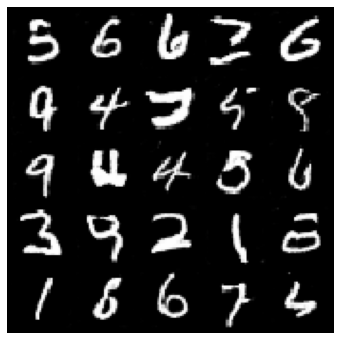

In [ ]:
z = torch.randn(25, 100, device=device)
samples = generator(z).data.cpu()
grid = utils.make_grid(samples, 5, normalize=True)

plt.figure(figsize=(6,6))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()